In [2]:
# importing general libraries
import pandas as pd
import numpy as np
import copy
import itertools
from matplotlib import pyplot as plt
%matplotlib inline

# importing ML libraries
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# importing visual analysis 
from IPython.display import Image

## Read in Data

In [3]:
#click_train_data= pd.read_csv("clicks_train_features.csv")
train_data = pd.read_csv('../input/trainingdata.csv')
train_labels = pd.read_csv('../input/traininglabels.csv')
dev_data = pd.read_csv('../input/developmentdata.csv')
dev_labels =pd.read_csv('../input/developmentlabels.csv')

In [3]:
#convert train labels into an array, so sklearn accepts them
train_labels =train_labels["0"]
dev_labels = dev_labels["0"]

In [4]:
#get rid of the categorical variables we can't use for regression and decision trees
full_train = train_data[train_data.columns[11:]].fillna(0)
full_dev = dev_data[dev_data.columns[11:]].fillna(0)
#Make small version of the data for GridSearch (otherwise it is unbelieveably slow)
mini_train =full_train[:5000]
mini_dev = full_train[5000:7000]
mini_train_labels = train_labels[:5000]
mini_dev_labels = train_labels[5000:7000]

## Logistic Regression

**Rationale:** 
We started with logistic regression (we could not use linear since we have a binary response variable) since the large number of cases would make it more accurate than techniques like Naive Bayes.
Although some of the regession assumptions are violated (chiefly multifolinearity), we decided to continue anyway because the focus of this challenge is getting the best prediction rather than identifying accurately the size of each individual coefficient.

**Approach:**
We first fit a logistic regression model without regularization, using all the binarized features (representing document category, topic etc) and continuous features reprenting the percent of ads from that ad campaign that had been clicked, the percent of ads from that advertiser that had been clicked, the frequency of document views, and the percentage of that ad that had been clicked.

Then we use grid search to identify the optimal level of regularization and whether l2 or l1 regularization would perform better. We expected l1 regularization to be superior because it more harshly penalizes very low weighted features. 

Finally, we tried exercising our domain knowledge/judgement and running a regression with only the four predictors we expected to be most predictive, which were the percent of ads from that ad campaign that had been clicked, the percent of ads from that advertiser that had been clicked, the frequency of document views, and the percentage of that ad that had been clicked. 

**Exploration of Some Key Variables**

The click percent is correlated 0.866557250489 with the campaign percent.
The advertiser percent is correlated 0.831655161645 with the campaign percent.
The advertiser percent is correlated 0.811708146085 with the click percent
The advertiser percent is correlated 0.08089912812 with document frequency.
Other representative variables are not excessively correlated.
0.000134479244919
0.00135907055519
-0.000873503139683
0.00696351770159
0.00516579974675


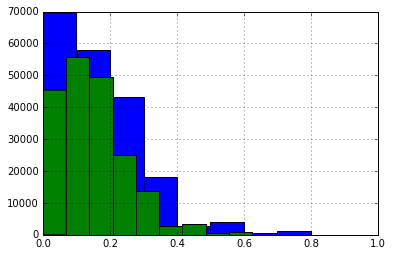

In [29]:
# Multicollinearity
print("The click percent is correlated", train_data['click_perc'].corr(train_data['campaign_perc']), "with the campaign percent.")
print("The advertiser percent is correlated", train_data['advertiser_perc'].corr(train_data['campaign_perc']), 'with the campaign percent.')
print("The advertiser percent is correlated",train_data['advertiser_perc'].corr(train_data['click_perc']), 'with the click percent')
print("The advertiser percent is correlated", train_data['advertiser_perc'].corr(train_data['docx_view_freq']), "with document frequency.")
print("Other representative variables are not excessively correlated.")
print(train_data['cat_1000'].corr(train_data['cat_1210']))
print(train_data['top_200'].corr(train_data['cat_1210']))
print(train_data['cat_1000'].corr(train_data['top_130']))
print(train_data['cat_1000'].corr(train_data['campaign_perc']))
print(train_data['cat_1000'].corr(train_data['click_perc']))


# there are some higher correlations between advertiser_perc, campaign_perc, and click_perc which make sense
# because advertisers have their own campaigns and each advertisement belongs to an advertiser and a campaign

# Shape of Predictor Variables
train_data['advertiser_perc'].hist()
np.log1p(train_data['advertiser_perc']).hist()
# transformation didn't make that much more normal, but normality is a weaker assumption that doesn't have to be fulfilled...

** Regression with all features, unregularized**

In [30]:
#with all regressable features
lr = LogisticRegression()
lr.fit(full_train, train_labels)
lr_score_1 = lr.score(full_dev, dev_labels)
print("The accuracy is", lr_score_1, "using all possible features")

The accuracy is 0.859842668494 using all possible features


** Regression using regularization to reduce features **

In [31]:
#grid search runs on the smaller data because running it on the full data takes too long for a demo notebook
lr = LogisticRegression()
C = {"C": [.01, .05, 0.1, .2, .5, 1 , 10, 100], 'penalty':["l1", "l2"]}
search = GridSearchCV(lr, param_grid = C)
lr_params = search.fit(full_train, train_labels)
lr_best = lr_params.best_params_
lr = LogisticRegression(C= lr_best["C"], penalty = lr_best["penalty"])
lr.fit(full_train, train_labels)
lr_score_2 = lr.score(full_dev, dev_labels)
print("The accuracy is", lr_score_2, "using regularization with the best parameters idenfitied by grid search.")
print ("These parameters are:", lr_best["penalty"], 'penalty and',lr_best["C"], 'C.')
print ("This leaves", np.count_nonzero(lr.coef_), "non-zero parameters.")

The accuracy is 0.860161583709 using regularization with the best parameters idenfitied by grid search.
These parameters are: l1 penalty and 0.5 C.
This leaves 126 non-zero parameters.
These features are ['top_0', 'top_1', 'top_2', 'top_8', 'top_11', 'top_16', 'top_20', 'top_26', 'top_36', 'top_37', 'top_43', 'top_44', 'top_52', 'top_61', 'top_64', 'top_66', 'top_68', 'top_74', 'top_85', 'top_92', 'top_93', 'top_97', 'top_102', 'top_107', 'top_113', 'top_127', 'top_131', 'top_136', 'top_138', 'top_140', 'top_147', 'top_148', 'top_154', 'top_160', 'top_161', 'top_174', 'top_183', 'top_184', 'top_185', 'top_191', 'top_192', 'top_198', 'top_199', 'top_215', 'top_227', 'top_232', 'top_238', 'top_239', 'top_240', 'top_249', 'top_250', 'top_265', 'top_271', 'top_287', 'top_291', 'top_292', 'top_294', 'top_296', 'cat_1100', 'cat_1202', 'cat_1203', 'cat_1204', 'cat_1205', 'cat_1206', 'cat_1207', 'cat_1208', 'cat_1210', 'cat_1211', 'cat_1302', 'cat_1303', 'cat_1402', 'cat_1403', 'cat_1405', 'ca

The features with the largest coefficients: (with a caveat that multicolinearity complicates interpreting the coefficients of the four % features)

In [70]:
coef = list(lr.coef_[0])
cols = list(mini_train.columns.values)
feature_imp = pd.DataFrame({"coef":coef, "cols": cols})
feature_imp.tail()
feature_imp.sort_values('coef', ascending = False, inplace = True)
feature_imp['cols'][:10]

396    campaign_perc
398       click_perc
184          top_184
174          top_174
238          top_238
8              top_8
199          top_199
37            top_37
131          top_131
382         cat_1910
Name: cols, dtype: object

Full Classification Report:

In [8]:
preds = lr.predict(full_dev)
print(classification_report(dev_labels, preds))

             precision    recall  f1-score   support

          0       0.87      0.99      0.92     72008
          1       0.65      0.14      0.23     12654

avg / total       0.83      0.86      0.82     84662



The f1-score especially for class 1 ('clicked") is rather low. 

The precision (proportion to ads predicted 'clicked' that were actually clicked is OK (.65)) but the recall is very poor (many adds that were actually clicked are being predicted "unclicked").

Lets visualize this with a confusion matrix:

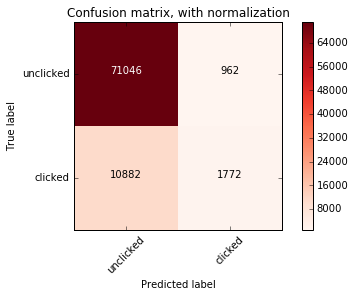

In [18]:
#code reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(dev_labels, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["unclicked", "clicked"],
                      title='Confusion matrix, with normalization')

** Regression Model Training using the Four 'Logically' chosen Groups **

In [32]:
lr = LogisticRegression()
lr.fit(full_train[full_train.columns[-4:]], train_labels)
lr_score_3 = lr.score(full_dev[full_dev.columns[-4:]], dev_labels)
print("The accuracy is", lr_score_3, "using the top 'logically chosen' features.")
print("\n")

The accuracy is 0.85996078524 using the top 'logically chosen' features.




## Regression Conclusions:
Regularization doesn't make much of difference.
The highest accuracy achieved is about 86%. 
The 4 added features performed well, although only campaign % clicked and ad % clicked were in the top 10 largest coeficients.

# Decision Trees and Random Forest

**Rationale:** A random forest algorithm seemed like the perfect technique to approach this since it is a classification problem (ads are either clicked or not clicked) and we had a very large number of features, many of which are likely irrelevant. Random Forest models address decision trees issues with over fitting by averaging the results of many different decision trees trained on different sub samples of the data. This increases variance but decreases bias, leading to more accurate prediction on test data. 

**Approach:** We trained first a standard decision tree, and then trained a random forest model using grid search to optimize the maximum number of features the trees would use, the number of trees, and the information gain criterion (either gini or entropy). We then scored the model using the best features. 
We also then fit an extra trees model, which tends towards a larger number of leaves, using the same grid search parameters as with the random forest. 

** Single Decision Tree **

In [24]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(full_train, train_labels)
print("A single decision tree got an accuracy of", dec_tree.score(full_dev, dev_labels))

A single decision tree got an accuracy of 0.847393163403


In [27]:
#tree.export_graphviz(dec_tree,out_file='tree.dot')  
#system("dot -Tpng 'tree.dot' -o tree.png") 

** Baseline Random forest**

In [34]:
forest = RandomForestClassifier(random_state = 1)
forest = forest.fit(full_train, train_labels)
forest.score(full_dev, dev_labels)

0.84429850464198819

** Random forest with grid search to identify optimal parameters **

In [35]:
parameters = {'n_estimators':[10, 50, 100, 200], 'criterion': ["gini", "entropy"]}
forest = RandomForestClassifier(random_state = 1)
search = GridSearchCV(forest, param_grid = parameters, scoring = "f1_micro")
forest_params = search.fit(mini_train, mini_train_labels)
forest_best = forest_params.best_params_
forest = RandomForestClassifier(random_state = 1, max_features = 'auto', n_estimators = forest_best['n_estimators'], criterion = forest_best['criterion'])
forest.fit(full_train, train_labels)
forest.score(full_dev, dev_labels)
print("A random forest with optimal parameters got an accuracy of", forest.score(full_dev, dev_labels))
print("With", forest_best['n_estimators'], 'trees and', forest_best['criterion'], "as the criterion")

A random forest with optimal parameters got an accuracy of 0.858283527439
With 200 trees and gini as the criterion


The most important features were:

In [58]:
features = forest.feature_importances_
features = list(forest.feature_importances_)
cols = list(mini_train.columns.values)
feature_imp = pd.DataFrame({"features":features, "cols": cols})
feature_imp.sort_values('features', ascending = False, inplace = True)
feature_imp['cols'][:10]
#features[0:10]

397     docx_view_freq
398         click_perc
396      campaign_perc
395    advertiser_perc
376           cat_1903
183            top_183
321           cat_1403
160            top_160
326           cat_1408
379           cat_1907
Name: cols, dtype: object

The four engineered features were the 4 most important features in forming this random forest, followed by other binary variables for certain categories and topics.

The full classification report:

In [19]:
forest = RandomForestClassifier(random_state = 1, max_features = 'auto', n_estimators = 200, criterion = 'gini')
forest.fit(full_train, train_labels)
preds = forest.predict(full_dev)
print(classification_report(dev_labels, preds))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92     72008
          1       0.59      0.18      0.27     12654

avg / total       0.83      0.86      0.82     84662



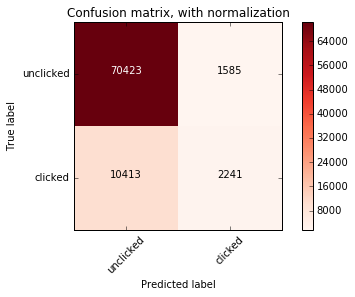

In [20]:
cnf_matrix = confusion_matrix(dev_labels, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["unclicked", "clicked"],
                      title='Confusion matrix, with normalization')

The scores for predicting class 1 (an ad was clicked) are much much lower than for predicting an ad not being clicked. 

Similar to regression, precision for 'clicked ads' is ok, recall is awful. So lots of ads that were clicked are not being identified. 

** Extra Trees with grid search to identify optimal parameters**

In [36]:
parameters = {'n_estimators':[10, 50, 100, 200], 'criterion': ["gini", "entropy"]}
extrees = ExtraTreesClassifier(random_state = 1)
search = GridSearchCV(extrees, param_grid = parameters, scoring = "f1_micro")
extrees_params = search.fit(mini_train, mini_train_labels)
extrees_best = extrees_params.best_params_
trees = ExtraTreesClassifier(random_state = 1, max_features = 'auto', n_estimators = forest_best['n_estimators'], criterion = forest_best['criterion'])
extrees.fit(full_train, train_labels)
extrees.score(full_dev, dev_labels)
print("A Extra Trees forest with optimal parameters got an accuracy of", extrees.score(full_dev, dev_labels))
print("With", extrees_best['n_estimators'], 'trees and ', extrees_best['criterion'], "as the criterion")

A Extra Trees forest with optimal parameters got an accuracy of 0.837908388651
With 10 trees and  entropy as the criterion


## Decision Tree Conclusion:
Random Forest performs slightly better than a single decision and has a very similar accuracy to that of regression (.86)

# KMeans Model

**Rationale:** Kmeans is not necessarily the ideal approach because it assumes that each feature is equally important -- it minimizes distance in all features equally -- which is clearly not the case here. Nevertheless, we decided to try.

**Approach** We tried first kmeans on the full features with 1, 3, 5, and 10 neighbours. Then we tried it using a smaller subset of features - only the four specifically engineered features, but got similar results.

** Model with full features **

In [ ]:
def kmeans(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(full_train, train_labels)
        preds = neigh.predict(full_dev)
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5, 10]
kmeans(k_values)

# the prediction accuracy is still somewhat low
# the recall and precision of predicting an ad that was clicked (1) is extremeley low even with overfitting,
# so with more generalization and higher k-values, we don't expect much better.

# try again but only with the engineered variables of clicks, not including category/topic

k= 1 :              precision    recall  f1-score   support

          0       0.87      0.84      0.85     72008
          1       0.24      0.28      0.26     12654

avg / total       0.77      0.76      0.76     84662



** Reduced Feature Model **

In [12]:
def kmeans2(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(full_train[full_train.columns[-4:]], train_labels)
        preds = neigh.predict(full_dev[full_dev.columns[-4:]])
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5, 10]
kmeans2(k_values)

# even running on the last 4 columns, feature engineered to look at overall averages of clicks based on 
# other features like advertiser, campaign do not improve accuracy much

k= 1 :              precision    recall  f1-score   support

          0       0.87      0.84      0.86     72008
          1       0.25      0.30      0.27     12654

avg / total       0.78      0.76      0.77     84662

k= 3 :              precision    recall  f1-score   support

          0       0.87      0.91      0.89     72008
          1       0.32      0.24      0.27     12654

avg / total       0.79      0.81      0.80     84662

k= 5 :              precision    recall  f1-score   support

          0       0.87      0.94      0.90     72008
          1       0.36      0.20      0.26     12654

avg / total       0.79      0.83      0.81     84662



** Added Additional Feature **

In [14]:
# try binarizing platform & advertiser_id as more features for kmeans
# kmeans finds similar neighbors, calculates dissimilarity distances between rows
# so more differentiating factors can help kmeans find 'similar' neighbors for prediction
# advertiser and platform may be good features that differentiate clicks

# advertiser may take a while and kill the kernel, so feel free to keep it commented out

#advertiser = pd.get_dummies(train_data, columns={'advertiser_id'}, prefix="advertiser")
platform = pd.get_dummies(train_data.fillna(0), columns={'platform'}, prefix="platform")
train_data_kmeans = platform[platform.columns[:1].union(platform.columns[405:])]
#train_data_kmeans = train_data_kmeans.merge(advertiser[advertiser.columns[:1].union(advertiser.columns[409:])], on='display_id')
del train_data_kmeans["display_id"]

#advertiser_dev = pd.get_dummies(dev_data, columns={'advertiser_id'}, prefix="advertiser")
platform_dev = pd.get_dummies(dev_data.fillna(0), columns={'platform'}, prefix="platform")
dev_data_kmeans = platform_dev[platform_dev.columns[:1].union(platform_dev.columns[405:])]
#dev_data_kmeans = dev_data_kmeans.merge(advertiser_dev[advertiser_dev.columns[:1].union(advertiser_dev.columns[409:])], on='display_id')
del dev_data_kmeans["display_id"]

def kmeans3(k_values):

    for i in k_values:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(train_data_kmeans, train_labels)
        preds = neigh.predict(dev_data_kmeans)
        print("k=",i,":",classification_report(dev_labels, preds))

k_values = [1, 3, 5]
kmeans3(k_values)

k= 1 :              precision    recall  f1-score   support

          0       0.87      0.84      0.86     72008
          1       0.26      0.31      0.28     12654

avg / total       0.78      0.76      0.77     84662

k= 3 :              precision    recall  f1-score   support

          0       0.87      0.93      0.90     72008
          1       0.35      0.22      0.27     12654

avg / total       0.79      0.82      0.80     84662

k= 5 :              precision    recall  f1-score   support

          0       0.87      0.95      0.91     72008
          1       0.38      0.19      0.25     12654

avg / total       0.80      0.83      0.81     84662



## K-Means Conclusion:
Kmeans did not do a good job of predicting the correct "clicked" ads, the recall and precision of class 1 (clicked) was ~25% which is still not great. The overall f-score of ~.80 is not bad though. 

# Single Value Decomposition - Attempt
Much of this code is modeled of the class presentation on SVD

In [1]:
test = pd.read_csv('../input/clicks_test.csv')
clicks_train = pd.read_csv("../input/clicks_train.csv")

# Group the ads and count up how many views and clicks
ad_likelihood = clicks_train.groupby('ad_id')['clicked'].agg(['count','sum']).reset_index()

# Calculate the overall average number of clicks
mean_clicked = clicks_train.clicked.mean()
print("overall average click-rate:", mean_clicked)
# del clicks_train

# Calculate the likelihood of an ad click
ad_likelihood['likelihood'] = (ad_likelihood['sum']) / (ad_likelihood['count'] + 1)

# Left join the ad likelihoods into the training set by ad_id
test = test.merge(ad_likelihood,how='left')

# Fill in the blanks with the overall average likelihood
test.fillna(mean_clicked,inplace=True)

# Sort the rows by the likelihood of each ad_id within each display_id
test.sort_values(['display_id','likelihood'],inplace=True,ascending=False)

print("\nThis is our prior expectation for the ad click likelihoods based on overall click-rates...")
print(test.head(20))

# Format the data the way the submission requires
output=test.groupby(['display_id'])['ad_id'].apply(lambda x:' '.join(map(str,x))).reset_index()

# That's it for the simple solution (prior expectation)!
output.to_csv('simplesolution3.cvs',index=False)

NameError: name 'pd' is not defined

In [ ]:
#This transforms the training data into the format we need!
SVDtable = clicks_train.pivot(index='display_id', columns='ad_id')

#Give the NAs a -1 value for now.  Can replace later as necessary.
SVDtable = SVDtable.fillna('-1')
print(SVDtable.head())

# Converting to a np.array is tricky, so let's put it in a csv first and then re-import it.
SVDtable.to_csv('diditwork.csv',index=True, column_names=False)

In [ ]:
# re-import as numpy array for SVD spooky stuff
ff = "diditwork.csv"
f = open(ff)

junkline = f.readline() # says "clicked" a bunch of times
column_names = f.readline()
# print(column_names)
anotherjunkline = f.readline() #has "display_id" header with a bunch of NaN entries...

def converter(x):
    if x == -1:
        return np.nan # Why doesn't this work?  -1s show up everywhere
    else:
        return float(x)
    
data = np.loadtxt(f, delimiter=',', converters={1:converter})

print(data[:])

In [ ]:
# Let's set the NAs to 0 for now to match the joke recommender sample code...
data[:, 1:][data[:, 1:] == -1] = 0 # np.nan

print(data[:])
print(data.shape)
print(type(data))

# only one click each row!?
print(np.sum(data[0][1:]))
print(np.sum(data[1][1:]))
print(np.sum(data[2][1:]))
print(np.sum(data[3][1:]))
print(np.sum(data[4][1:]))

In [ ]:
# full svd; note that the first column is dropped since it's the display_id
u, s, v = np.linalg.svd(data[:, 1:], full_matrices=False)

print(u.shape)
print(s.shape)
print(v.shape)

# these are (nearly) the same, that's the decomposition!
print(data[:, 1:])

print(np.dot(np.dot(u, np.diag(s)), v)) # the full reconstruction

In [ ]:
n_comp = 10

# make a new s vector with only the first few values kept
s_padded = np.zeros(len(s))
s_padded[:n_comp] = s[:n_comp]

filled_in = np.dot(np.dot(u, np.diag(s_padded)), v)

# Okay, this is bad.  Why are the recommendations all zero?  Too sparse??
print(filled_in)

# No recommendations!!!
print(np.sum(filled_in[0][:]))
print(np.sum(filled_in[1][:]))
print(np.sum(filled_in[2][:]))
print(np.sum(filled_in[3][:]))

# Conclusion

Linear regression and random forest models produced similar accuracies (around 86%). 

Given the nature of the data - many irrelevant features and strong multicolinearity between some features - random forest is the logically best choice and since it is equally effective, we will conclude that our final model is a Random Forest, with 200 trees and gini as the evaluation criteria. 